<a href="https://colab.research.google.com/github/RaiShra1/Computer-Vision-and-Image-Processing/blob/main/CIFAR10_Classification_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_transform = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(20),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])

validation_transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [ ]:
training_dataset = datasets.CIFAR10(root='./data', train=True,
                                    download=True, transform=train_transform)
 # Data augmentation is only done on training images
validation_dataset = datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=validation_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
 training_loader = torch.utils.data.DataLoader(training_dataset,
                                               batch_size=100, shuffle=True) 
validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                                batch_size = 100, shuffle=False)

In [ ]:
def tensor2im(tensor):  
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [ ]:
# Different classes in CIPHAR 10 dataset. 
classes = ('plane', 'car', 'bird', 'cat', 'deer',\
           'dog', 'frog', 'horse', 'ship', 'truck')

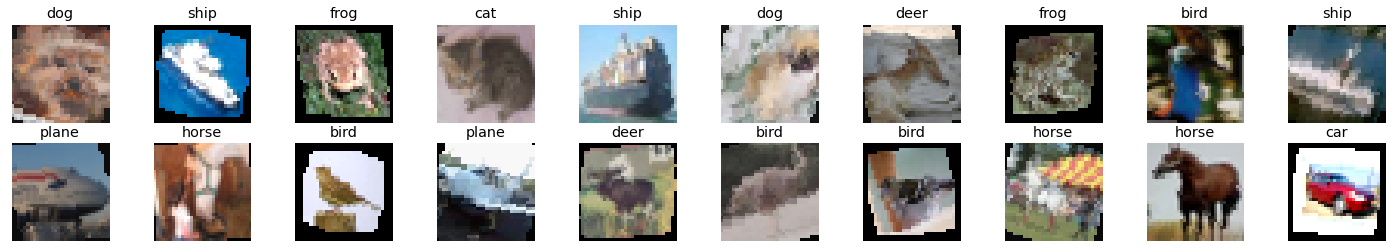

In [ ]:
dataiter = iter(training_loader) # converting train_dataloader to iterable 
                                 #so that we can iter through it. 
images, labels = dataiter.next() #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(25, 4)) 

# We plot 20 images from our train_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(tensor2im(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title(classes[labels[idx].item()])

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


In [ ]:
model = ResNet50().to(device) # run our model on cuda GPU for faster results
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

In [ ]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) 

In [ ]:
epochs = 20
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs): # training our model, put input according to every batch.
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device) # send input to gpu
    labels = labels.to(device)
    outputs = model(inputs) # every batch of 100 images are put as an input.
    loss = criterion(outputs, labels) # Calc loss after each batch
    
    optimizer.zero_grad() #setting the initial gradient to 0
    loss.backward() # backpropagating the loss
    optimizer.step() # updating the weights and bias values for every single step.
    
    _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad(): # we do not need gradient for validation.
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader) # loss per epoch
    epoch_acc = running_corrects.float()/ len(training_loader) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying 
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.7072, acc 37.8580 
validation loss: 1.3670, validation acc 50.0600 
epoch : 2
training loss: 1.2693, acc 53.8220 
validation loss: 1.0915, validation acc 60.7000 
epoch : 3
training loss: 1.0900, acc 61.1900 
validation loss: 0.9224, validation acc 67.0300 
epoch : 4
training loss: 0.9678, acc 65.7860 
validation loss: 0.9197, validation acc 67.7700 
epoch : 5
training loss: 0.8712, acc 69.6240 
validation loss: 0.7171, validation acc 74.7600 
epoch : 6
training loss: 0.7818, acc 72.7840 
validation loss: 0.6946, validation acc 75.8500 
epoch : 7
training loss: 0.7274, acc 74.5420 
validation loss: 0.5980, validation acc 79.7000 
epoch : 8
training loss: 0.6756, acc 76.6220 
validation loss: 0.5767, validation acc 80.2400 
epoch : 9
training loss: 0.6357, acc 77.8940 
validation loss: 0.5716, validation acc 80.3500 
epoch : 10
training loss: 0.5931, acc 79.4020 
validation loss: 0.5211, validation acc 82.4800 
epoch : 11
training loss: 0.5599, acc 80.5160 
va

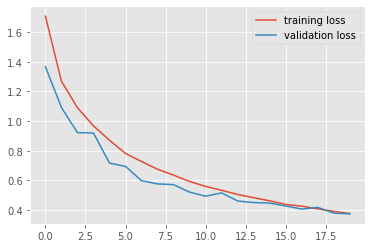

In [ ]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

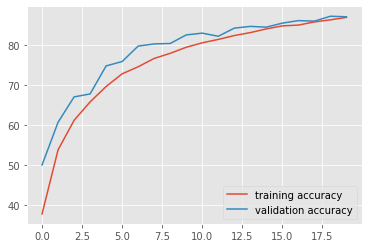

In [ ]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving stefan-rodriguez-2AovfzYV3rc-unsplash.jpg to stefan-rodriguez-2AovfzYV3rc-unsplash.jpg


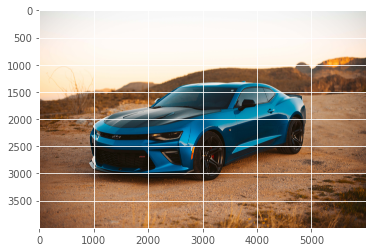

In [ ]:
import requests
from PIL import Image

img = plt.imread('/content/stefan-rodriguez-2AovfzYV3rc-unsplash.jpg')
plt.imshow(img)
plt.show()

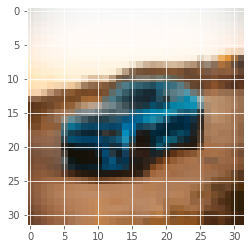

In [ ]:
from PIL import Image
from matplotlib import cm

im = Image.fromarray(np.uint8(img))
img = validation_transform(im) 
plt.imshow(tensor2im(img))

In [ ]:
image = img.to(device).unsqueeze(0) # put inputs in device as our model is running there
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

plane


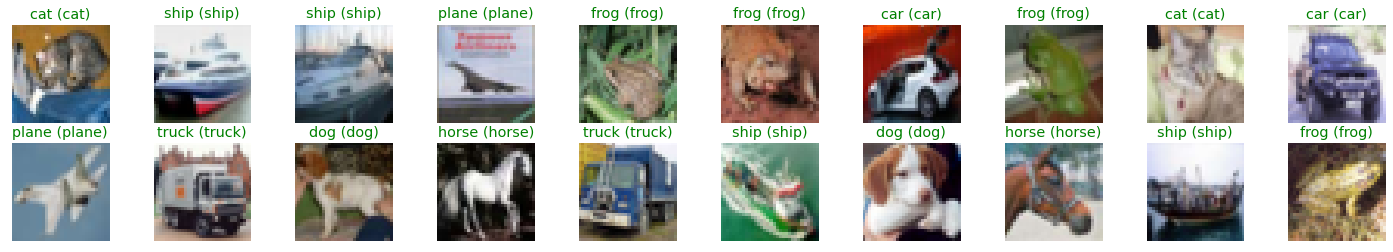

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(tensor2im(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]),\
                                str(classes[labels[idx].item()])),\
                color=("green" if preds[idx]==labels[idx] else "red"))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
c = (preds == labels).squeeze()
for i in range(100):
    label = labels[i]
    class_correct[label] += c[i].item()
    class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 90 %
Accuracy of   car : 100 %
Accuracy of  bird : 87 %
Accuracy of   cat : 90 %
Accuracy of  deer : 100 %
Accuracy of   dog : 87 %
Accuracy of  frog : 93 %
Accuracy of horse : 81 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %
